In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
results = {}

In [ ]:
def lstm_predict(train_X, train_y, test_X):
    """ lstm_predict """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(10, 1))) # 50 LSTM units
    model.add(Dense(1)) # Output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    # Train the model
    model.fit(train_X, train_y, epochs=100, verbose=0)
    # Make predictions
    X_test = np.random.rand(5, 10, 1)
    predictions = model.predict(test_X)
    return predictions

In [24]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


```python
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout,  Dense
from tensorflow.keras.regularizers import l1_l2, l2

total_words = 478
max_sequence_len = 90
model = Sequential()
Layer1 = model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
Layer2 = model.add(Bidirectional(LSTM(20, return_sequences=True)))
Layer3 = model.add(Dropout(.03))
Layer4 = model.add(LSTM(20))
Layer5 = model.add(Dense(total_words, 
    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=l2(1e-4),
    activity_regularizer=l2(1e-5)))
          # A Dense Layer including regularizers
Layer6 = model.add(Dense(total_words, activation = 'softmax'))
          
# Pick an optimizer
          
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
```

In [38]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example data
data = np.array([[1], [2], [3], [4], [5]])

# Initialize and fit-transform the scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled Data:")
print(scaled_data)

# Restore the original data using inverse_transform
restored_data = scaler.inverse_transform(scaled_data)

print("\nRestored Data:")
print(restored_data)


Scaled Data:
[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]

Restored Data:
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]


     rounds  matched_cnts
0       771             0
1       772             2
2       773             0
3       774             1
4       775             2
..      ...           ...
400    1171             0
401    1172             0
402    1173             0
403    1174             2
404    1175             1

[405 rows x 2 columns]


/home/swhors/bin/jupyter_venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Squared Error: 1.1910669975186103
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0

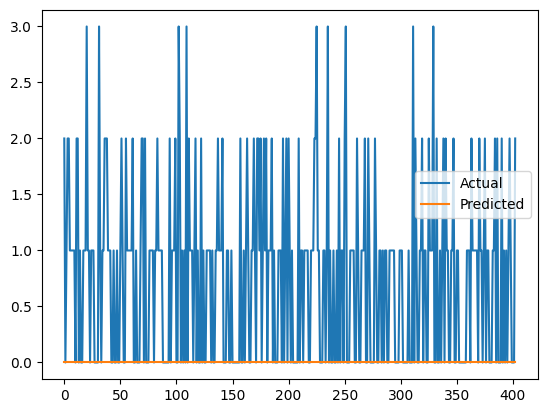

In [71]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    metrics = metrics[0].split('|')
    return metrics[0], metrics[1]


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

verbose = 0

version = "T_01_10"
db_file_path = '../db/metrics.db'
random_state = 113789
rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
rounds = []
matched_cnts = []
test_X = 1376
for i in rounds_str.split(','):
    rounds.append(int(i))
for i in matched_cnts_str.split(','):
    matched_cnts.append(int(i))
rounds.reverse()
matched_cnts.reverse()

if verbose > 0:
    print('rounds', rounds)
    print('matched_cnts', matched_cnts)

df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
print(df)

data = df['matched_cnts'].values.reshape(-1, 1)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

seq_length = 1
X, y = create_sequences(scaled_data, seq_length)

# 2. Model Building
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(units=50, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
model.add(LSTM(units=50, activation='relu'))
# model.add(Dense(units=1,activation='relu'))
model.add(Dense(units=1,activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(optimizer='adam', loss='binary_crossentropy')

# model.add(LSTM(units=45, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu', return_sequences=True))
# model.add(LSTM(units=45, activation='relu'))
# model.add(Dense(units=1, activation='relu'))
# model.compile(optimizer='adam', loss='binary_crossentropy')
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_features, activation='sigmoid'))
    
# binary_crossentropy는 각 번호가 나올지/안나올지를 독립적으로 판단하는 다중 라벨 문제에 적합


# 3. Training
model.fit(X, y, epochs=45, batch_size=1, verbose=verbose)

# 4. Evaluation
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")
print(y_pred)
# y_pred = [i * 10.0 for i in y_pred]

# print(y_pred)


plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Data Preparation
df = pd.read_csv('your_time_series_data.csv')
data = df['your_time_series_column'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)



seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# 2. Model Building
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Training
model.fit(X, y, epochs=100, batch_size=32)

# 4. Evaluation
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. 데이터 준비
# 예시 데이터 생성 (실제 데이터로 교체 필요)
time_steps = 10
data_dim = 1
num_samples = 100

X = np.random.rand(num_samples, time_steps, data_dim)
y = np.random.rand(num_samples, 1)

print(X)
print(y)

# 2. 모델 구성
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, data_dim)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 3. 모델 훈련
model.fit(X, y, epochs=10, batch_size=32)

# 4. 예측
predictions = model.predict(X)

print(predictions)

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
from tqdm import tqdm

# 딥러닝 라이브러리 TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MultiLabelBinarizer

# 시퀀스 길이 (과거 몇 회차의 데이터를 보고 다음을 예측할 것인가)
SEQUENCE_LENGTH = 10


def create_sequences(data, seq_length):
    """
    데이터를 LSTM 학습에 맞는 시퀀스 형태로 변환합니다.
    """
    xs = []
    ys = []
    # Multi-hot 인코딩을 위해 1~45번까지의 클래스를 명시적으로 지정
    mlb = MultiLabelBinarizer(classes=list(range(1, 46)))
    
    # 전체 데이터를 Multi-hot 벡터로 변환
    encoded_data = mlb.fit_transform(data)
    
    for i in tqdm(range(len(encoded_data) - seq_length), desc="시퀀스 데이터 생성 중"):
        # 입력 시퀀스 (X): i부터 i+seq_length-1 까지
        xs.append(encoded_data[i:(i + seq_length)])
        # 타겟 (y): i+seq_length
        ys.append(encoded_data[i + seq_length])
        
    return np.array(xs), np.array(ys), mlb


def build_lstm_model(seq_length, num_features, neural_num=128, verbose=0, activation='sigmoid'):
    """
    LSTM 모델을 생성합니다.
    """
    model = Sequential()
    # 입력층: LSTM 레이어, input_shape=(시퀀스 길이, 피처 개수)
    model.add(LSTM(neural_num, return_sequences=True, activation=activation, input_shape=(seq_length, num_features)))
    model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    # model.add(LSTM(neural_num, return_sequences=True, activation=activation))
    model.add(Dropout(0.2))
    # 중간층: LSTM 레이어
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    # 출력층으로 가기 전 Dense 레이어
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_features, activation='sigmoid'))
    
    # 모델 컴파일
    # binary_crossentropy는 각 번호가 나올지/안나올지를 독립적으로 판단하는 다중 라벨 문제에 적합
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    if verbose > 0:
        model.summary()
    return model


file_names = [
    (1174, 'xlsx/1173.xlsx', [8, 11, 14, 17, 36, 39]),
    (1175, 'xlsx/1174.xlsx', [3, 4, 6, 8, 32, 42]),
    (1176, 'xlsx/1175.xlsx', [0, 0, 0, 0, 0, 0])
    ]



for file_name in file_names:
    # --- 코드 실행 ---
    # 1. 역대 당첨 번호 데이터 가져오기
    lotto_history = get_lotto_history(*file_name, row_end=10)
    if lotto_history is not None:
        neural_num = 64
        # 2. 데이터 전처리 및 시퀀스 생성
        X, y, mlb = create_sequences(lotto_history, SEQUENCE_LENGTH)
    
        # 3. LSTM 모델 빌드
        # num_features는 로또 번호의 개수(45)
        model = build_lstm_model(SEQUENCE_LENGTH, X.shape[2], neural_num=neural_num)
    
        # 4. 모델 학습 (데이터가 많아 시간이 소요될 수 있습니다)
        print("\nLSTM 모델 학습을 시작합니다...")
        model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    
        # 5. 1176회 예측
        print(f"\{file_name[0]}회 예측을 시작합니다...")
    
        # 예측을 위해 가장 마지막 시퀀스를 입력으로 사용
        last_sequence_raw = lotto_history[-SEQUENCE_LENGTH:]
        last_sequence_encoded = mlb.transform(last_sequence_raw)
    
        # Keras 모델은 배치 입력을 기대하므로 차원을 추가 (samples, timesteps, features)
        input_for_prediction = np.expand_dims(last_sequence_encoded, axis=0)
    
        # 예측 실행 (결과는 각 번호가 나올 확률)
        predicted_probabilities = model.predict(input_for_prediction)[0]
    
        # 확률이 높은 순으로 6개 번호의 인덱스를 추출
        # argsort는 값을 정렬했을 때의 원래 인덱스를 반환
        top_6_indices = np.argsort(predicted_probabilities)[-6:]
    
        # 인덱스는 0부터 시작하므로 1을 더해 실제 로또 번호로 변환
        predicted_numbers = sorted([int(i + 1) for i in top_6_indices])
        if file_name[0] not in results:
            results[file_name[0]] = [predicted_numbers]
        else:
            results[file_name[0]].append(predicted_numbers)
    
        print("\n--- 최종 예측 결과 ---")
        print(f"LSTM 모델 기반 {file_name[0]}회 예측 번호: {predicted_numbers} {neural_num}, ")

In [ ]:
version = "T_01_10"
db_file_path = '../db/metrics.db'
random_state = 113789
metrics = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
print(metrics)

In [ ]:
for result in results:
    print("라운드", result)
    for metric in results[result]:
        print(metric)

In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]